# Modelling

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv('Data/clean_data.csv')

df

,sentiment,raw_comm,nouns_comm
0,neutral,Technopolis plans to develop in stages an area...,Technopolis stages area meters order companies...
1,negative,The international electronic industry company ...,industry company tens employees facility layof...
2,positive,With the new production plant the company woul...,production plant company capacity increase dem...
3,positive,According to the company 's updated strategy f...,company strategy years term sales growth range...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,FINANCING growth strategy circuit boards PCBs
...,...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...,Share prices rebound bank stocks weakness
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,beer sales per cent litres beer sales cent litres
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...,profit mn mn vessel sales gain mn
4843,negative,Net sales of the Paper segment decreased to EU...,sales segment mn quarter mn quarter profit ite...


### Split the data

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)

# Display the class distribution in the training set before downsampling
print("Training set class distribution before downsampling:")
print(train_df['sentiment'].value_counts())

# Display the class distribution in the test set
print("Test set class distribution:")
print(test_df['sentiment'].value_counts())

Training set class distribution before downsampling:
neutral     2302
positive    1091
negative     483
Name: sentiment, dtype: int64
Test set class distribution:
neutral     576
positive    272
negative    121
Name: sentiment, dtype: int64


### Up sampling

In [5]:
# Determine the size of the largest class in the training set
max_class_size = train_df['sentiment'].value_counts().max()

# Upsample each sentiment class in the training set
train_positive = train_df[train_df['sentiment'] == 'positive'].sample(max_class_size, replace=True, random_state=42)
train_negative = train_df[train_df['sentiment'] == 'negative'].sample(max_class_size, replace=True, random_state=42)
train_neutral = train_df[train_df['sentiment'] == 'neutral'].sample(max_class_size, replace=True, random_state=42)

# Combine the upsampled dataframes
train_df_upsampled = pd.concat([train_positive, train_negative, train_neutral])

# Shuffle the combined dataframe to mix the classes
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the class distribution after downsampling in the training set
print("Training set class distribution after downsampling:")
print(train_df_upsampled['sentiment'].value_counts())


Training set class distribution after downsampling:
negative    2302
positive    2302
neutral     2302
Name: sentiment, dtype: int64


### TF-IDF Vectorization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill NaN values in 'nouns_comm' and 'raw_comm' columns with an empty string
train_df_downsampled['nouns_comm'] = train_df_downsampled['nouns_comm'].fillna('')
train_df_downsampled['raw_comm'] = train_df_downsampled['raw_comm'].fillna('')
test_df['nouns_comm'] = test_df['nouns_comm'].fillna('')
test_df['raw_comm'] = test_df['raw_comm'].fillna('')

# TF-IDF Vectorization for 'nouns_comm' and 'raw_comm'
tfidf_vectorizer_nouns = TfidfVectorizer()
tfidf_vectorizer_raw = TfidfVectorizer()

X_train_nouns = tfidf_vectorizer_nouns.fit_transform(train_df_downsampled['nouns_comm'])
X_test_nouns = tfidf_vectorizer_nouns.transform(test_df['nouns_comm'])

X_train_raw = tfidf_vectorizer_raw.fit_transform(train_df_downsampled['raw_comm'])
X_test_raw = tfidf_vectorizer_raw.transform(test_df['raw_comm'])

y_train = train_df_downsampled['sentiment']
y_test = test_df['sentiment']


## Naive Bayes Model

### Train the model

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes models for both 'nouns_comm' and 'raw_comm'
nb_nouns = MultinomialNB()
nb_raw = MultinomialNB()   

# Fit the models
nb_nouns.fit(X_train_nouns, y_train)
nb_raw.fit(X_train_raw, y_train)

# Predict on the training set
y_train_pred_nouns = nb_nouns.predict(X_train_nouns)
y_train_pred_raw = nb_raw.predict(X_train_raw)

# Predict on the test set
y_test_pred_nouns = nb_nouns.predict(X_test_nouns)
y_test_pred_raw = nb_raw.predict(X_test_raw)


### Compute models' accuracy

In [12]:
# Evaluate the Naive Bayes model on the test set ('nouns_comm')
print("\nTest Set - Naive Bayes Model on 'nouns_comm'")
print("Accuracy:", accuracy_score(y_test, y_test_pred_nouns))
print("Classification Report:\n", classification_report(y_test, y_test_pred_nouns))

# Evaluate the Naive Bayes model on the test set ('raw_comm')
print("\nTest Set - Naive Bayes Model on 'raw_comm'")
print("Accuracy:", accuracy_score(y_test, y_test_pred_raw))
print("Classification Report:\n", classification_report(y_test, y_test_pred_raw))



Test Set - Naive Bayes Model on 'nouns_comm'
Accuracy: 0.5830753353973168
Classification Report:
               precision    recall  f1-score   support

    negative       0.33      0.65      0.44       121
     neutral       0.79      0.64      0.71       576
    positive       0.45      0.43      0.44       272

    accuracy                           0.58       969
   macro avg       0.52      0.57      0.53       969
weighted avg       0.64      0.58      0.60       969


Test Set - Naive Bayes Model on 'raw_comm'
Accuracy: 0.6800825593395253
Classification Report:
               precision    recall  f1-score   support

    negative       0.44      0.80      0.57       121
     neutral       0.83      0.73      0.78       576
    positive       0.57      0.51      0.54       272

    accuracy                           0.68       969
   macro avg       0.62      0.68      0.63       969
weighted avg       0.71      0.68      0.69       969



### Add predictions in the test_df

In [13]:
test_df['NB_pred_noun'] = y_test_pred_nouns
test_df['NB_pred_raw'] = y_test_pred_raw

test_df

,sentiment,raw_comm,nouns_comm,NB_pred_noun,NB_pred_raw
2783,neutral,"ALEXANDRIA , Va. , Dec. 17 -- Reijo Salovaara ...",veneer cutter,neutral,neutral
1566,positive,Nokia will continue to invest in future develo...,development benefit users,neutral,neutral
478,neutral,"Baltic Pearl CJSC , a subsidiary of Shanghai F...",subsidiary project meters space hospitals scho...,neutral,neutral
911,positive,This combined with foreign investments creates...,investments opportunities,neutral,neutral
1294,neutral,"Of course , you 'll have direct access to Noki...",access store lots fun media,neutral,neutral
...,...,...,...,...,...
4535,positive,Key shareholders of Finnish IT services provid...,shareholders services provider offer shop life...,neutral,neutral
141,positive,Finnish Bank of +_land reports its operating p...,land operating profit mn quarter mn period,negative,negative
945,positive,"EBITDA for the year 2009 improved to EUR484m ,...",EBITDA year,positive,positive
1523,positive,Finnish retailer Stockmann has won approval fr...,retailer approval board tender offer aim compa...,neutral,positive


## FNN

### FNN with nouns comm

#### Create the FNN architecture

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_fnn_model(input_dim, layers=1, nodes=32, learning_rate=0.001, dropout_rate=0.5, l2_reg=0.01):
    """
    Creates a feedforward neural network model with L2 regularization and dropout.
    
    Args:
        input_dim (int): Number of input features.
        layers (int): Number of hidden layers.
        nodes (int): Number of nodes per layer.
        learning_rate (float): Learning rate for the optimizer.
        dropout_rate (float): Dropout rate to prevent overfitting.
        l2_reg (float): L2 regularization strength.

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(nodes, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_reg)))
    
    # Add hidden layers with dropout and L2 regularization
    for _ in range(layers - 1):
        model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    
    # Output layer with 3 nodes for the 3 classes
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

#### Create the Grid Search and fit the model

In [37]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Function to create the KerasClassifier model for grid search
def build_keras_classifier(input_dim, layers, nodes, learning_rate, dropout_rate=0.5, l2_reg=0.01):
    return KerasClassifier(model=create_fnn_model, input_dim=input_dim, layers=layers, 
                           nodes=nodes, learning_rate=learning_rate, dropout_rate=dropout_rate, 
                           l2_reg=l2_reg, verbose=1)

# Define hyperparameters for grid search
param_grid = {
    'layers': [1, 2, 3],
    'nodes': [32, 64, 128],
    'epochs': [20, 30],
    'batch_size': [32, 64]
}

# Build the model
input_dim = X_train_nouns.shape[1]
model = build_keras_classifier(input_dim=input_dim, layers=1, nodes=32, learning_rate=0.001)

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=10,  # Stop if no improvement after 10 epochs
    verbose=1, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5,  # Reduce LR if no improvement after 5 epochs
    verbose=1, 
    min_lr=0.0001
)

# Perform Grid Search with EarlyStopping and ReduceLROnPlateau callbacks
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_nouns, y_train, callbacks=[early_stopping, reduce_lr])

2024-08-27 17:46:10.109508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 17:46:10.113955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 17:46:10.139327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 17:46:10.141731: I tensorflow/core/platform/cpu_featu

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4764 - loss: 1.2709
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5032 - loss: 1.2704
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4875 - loss: 1.4454
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4821 - loss: 1.2730
Epoch 2/20
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6630 - loss: 1.0162
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6392 - loss: 1.0111
Epoch 3/20
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6020 - loss: 1.0168
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6133 - loss: 1.0130
Epoch 3/20
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6837 - loss: 0.9763
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6513 - loss: 0.9760
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6743 - loss: 0.9742
Epoch 4/20
144/144 ━━

KeyboardInterrupt: 

#### Save the model

In [34]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

best_model = grid_result.best_estimator_

# Access the underlying Keras model
keras_model = best_model.model_

# Save the model in the recommended format
keras_model.save('FNN_nouns.keras')

# Load the model from the saved file
best_model = load_model('FNN_nouns.keras')

# Convert Sentiment labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Evaluate the loaded model with the encoded labels
best_model.evaluate(X_test_nouns, y_test_encoded)


/Users/robin/opt/anaconda3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6405 - loss: 3.2125


[3.146270513534546, 0.6388028860092163]

#### Print the mean cross validation accuracy per combination 

In [26]:
# Summarize the results from the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Extract the mean and standard deviation of test scores, and the corresponding parameters
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Print the results in a readable format
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.892123 using {'batch_size': 64, 'epochs': 20, 'layers': 2, 'learning_rate': 0.01, 'nodes': 128}
0.849986 (0.004983) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.001, 'nodes': 32}
0.855633 (0.002078) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.001, 'nodes': 64}
0.864031 (0.005807) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.001, 'nodes': 128}
0.876339 (0.001433) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.01, 'nodes': 32}
0.881118 (0.007854) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.01, 'nodes': 64}
0.880973 (0.003251) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.01, 'nodes': 128}
0.846800 (0.003199) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.1, 'nodes': 32}
0.856791 (0.008545) with: {'batch_size': 32, 'epochs': 20, 'layers': 1, 'learning_rate': 0.1, 'nodes': 64}
0.859687 (0.008666) with: {'b

#### Retrain the best model to store the history

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

# Retrieve the best hyperparameters from GridSearchCV
best_params = grid_result.best_params_

# Create the final model using the best parameters
best_model = create_fnn_model(
    input_dim=X_train_nouns.shape[1],
    layers=best_params['layers'],
    nodes=best_params['nodes'],
    learning_rate=best_params['learning_rate']
)

# Model Summary
print(best_model.summary())

# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model using the encoded labels
history = best_model.fit(
    X_train_nouns, y_train_encoded,  # <-- Use encoded labels here
    epochs=best_params['epochs'],  # Use the best number of epochs from the grid search
    batch_size=best_params['batch_size'],  # Use the best batch size from the grid search
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


/Users/robin/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       337,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,051 (1.35 MB)

 Trainable params: 354,051 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5574 - loss: 0.8827
Epoch 1: val_loss improved from inf to 0.44474, saving model to best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5588 - loss: 0.8806 - val_accuracy: 0.8321 - val_loss: 0.4447 - learning_rate: 0.0100
Epoch 2/20
82/87 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8961 - loss: 0.2805
Epoch 2: val_loss improved from 0.44474 to 0.32823, saving model to best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8966 - loss: 0.2795 - val_accuracy: 0.8835 - val_loss: 0.3282 - learning_rate: 0.0100
Epoch 3/20
71/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9386 - loss: 0.1552
Epoch 3: val_loss did not improve from 0.32823
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9389 - loss: 0.1552 - val_accuracy: 0.8842 - val_loss: 0.3526 - learning_rate: 0.0100
Epoch 4/20
84/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9565 - loss: 0.1172
Epoch 4: val_loss did not im

#### Plot the history of the loss function and accuracy

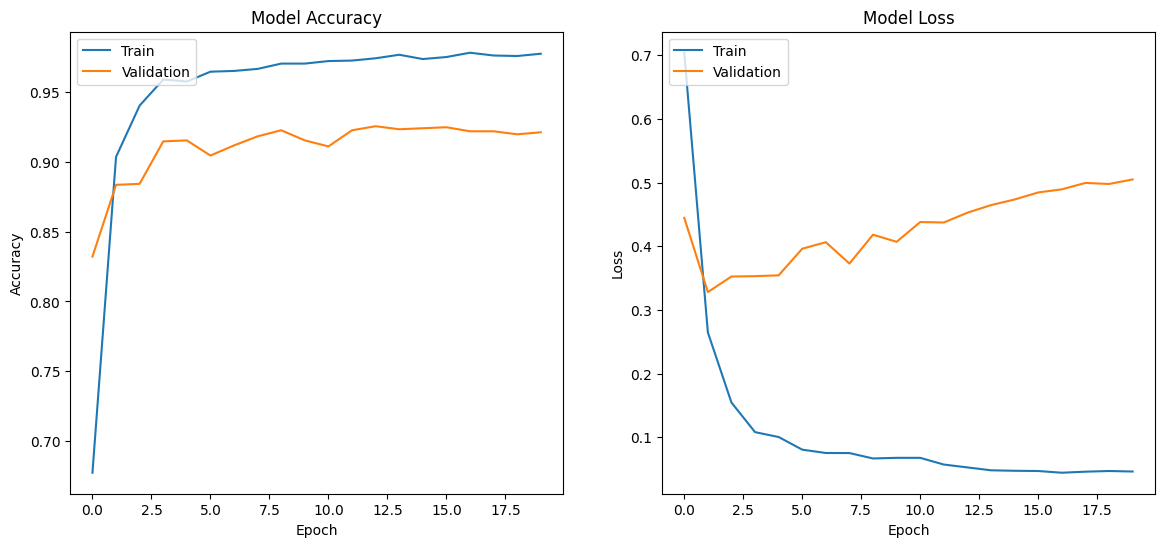

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history: Keras History object returned by model.fit().
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot the training and validation loss/accuracy using the history object
plot_training_history(history)


### Predict on the test with the best model

In [21]:
# Retrieve the best model from GridSearchCV
best_model = grid_result.best_estimator_

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_nouns)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


#### Compute metrics of the predictions

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_accuracy = best_model.score(X_test_nouns, y_test)
print("Test set accuracy: {:.4f}".format(test_accuracy))

# Generate a classification report
print(classification_report(y_test, y_test_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test set accuracy: 0.6388
              precision    recall  f1-score   support

    negative       0.42      0.52      0.46       121
     neutral       0.75      0.76      0.76       576
    positive       0.50      0.44      0.47       272

    accuracy                           0.64       969
   macro avg       0.56      0.57      0.56       969
weighted avg       0.64      0.64      0.64       969

[[ 63  35  23]
 [ 43 437  96]
 [ 44 109 119]]


# CHECK TO SEE IF THE MODEL IS BETTER WITH OVERFITING MEASURES BEFORE DOING THE SAME FOR RAW COMM

## FNN with raw comms